## using obspy + yt to extract properties along a seismic ray path 



In [1]:
import yt
import xarray as xr
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from obspy.taup import TauPyModel
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from pygeodesy.sphericalNvector import LatLon
import cartopy.crs as ccrs


## load the data into yt

In [2]:

ddir = "/home/chavlin/hdd/data/yt_data/IRIS_models/"
modelfile='GYPSUMS_kmps.nc'
xr_ds = xr.open_dataset(ddir+modelfile)
bbox = np.array([
    (xr_ds[dim].values[:].min(),xr_ds[dim].values[:].max()) for dim in xr_ds.vs.dims
])
bbox[1][0]=-89.99
bbox[1][1]=89.99
bbox[2][0]=0.001
bbox[2][1]=360 - 0.001

data = {'vs':xr_ds.vs.values}
ds = yt.load_uniform_grid(data,data['vs'].shape,1.0,bbox = bbox, 
                          geometry=("internal_geographic",
                                    ['depth','latitude','longitude']
                                   )
                         )

yt : [INFO     ] 2021-01-15 15:03:21,902 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-01-15 15:03:21,902 Parameters: domain_dimensions         = [112 181 361]
yt : [INFO     ] 2021-01-15 15:03:21,903 Parameters: domain_left_edge          = [  0.00000000e+00  -8.99899979e+01   1.00000005e-03]
yt : [INFO     ] 2021-01-15 15:03:21,903 Parameters: domain_right_edge         = [ 2900.            89.98999786   359.99899292]
yt : [INFO     ] 2021-01-15 15:03:21,903 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2021-01-15 15:03:21,909 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-01-15 15:03:22,040 xlim = 0.001000 359.998993
yt : [INFO     ] 2021-01-15 15:03:22,040 ylim = -89.989998 89.989998
yt : [INFO     ] 2021-01-15 15:03:22,041 xlim = 0.001000 359.998993
yt : [INFO     ] 2021-01-15 15:03:22,041 ylim = -89.989998 89.989998
yt : [INFO     ] 2021-01-15 15:03:22,043 Making a fixed resolution buffer of (('stream', 'vs')) 800 by 800
/home/chavlin/miniconda3/envs/yt_dev/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)



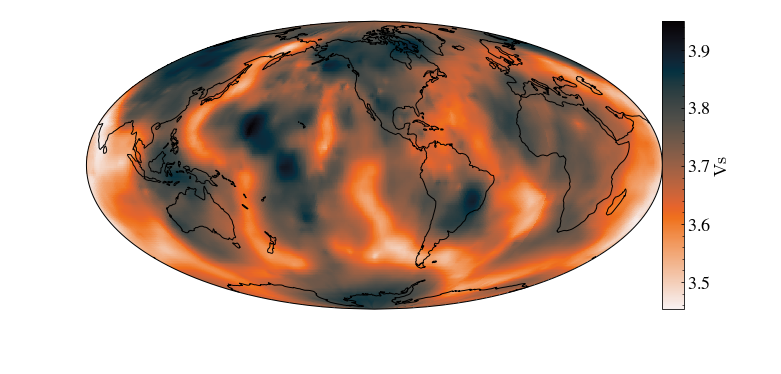

In [3]:

target_depth = 150
center = ds.domain_center
p = yt.SlicePlot(ds,"depth",'vs',center=[target_depth,center[1],center[2]]) 
p.set_cmap('vs', 'dusk_r')
p.set_log('vs', False)
 
p.set_mpl_projection(('Mollweide', (), {'central_longitude':-110}))#{'central_longitude':-100, 'central_latitude':40}))
#p.set_mpl_projection(('Mollweide', (), {'central_longitude':0}))#{'central_longitude':-100, 'central_latitude':40}))

p._setup_plots()

p.plots['vs'].axes.coastlines()
p.show()




## use obspy + pygeodesy to get event info and generate a ray path

In [4]:
client = Client()
cat = client.get_events(eventid=3279407) # Tohoku
cat.events

[Event:	2011-03-11T05:46:23.200000Z | +38.296, +142.498 | 9.1 MW

	            resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?eventid=3279407")
	             event_type: 'earthquake'
	    preferred_origin_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=18196524")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=176443936")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements]

In [5]:
event = cat.events[0]
depth_km = event.origins[0].depth / 100
lat = event.origins[0].latitude
lon = event.origins[0].longitude
[depth_km,lat,lon]

[197.0, 38.2963, 142.498]

In [6]:
stat = client.get_stations(network='HV',station='AIN')[0][0]
stat

Station AIN (Ainapo Ranch, Hawaii)
	Station Code: AIN
	Channel Count: 0/7 (Selected/Total)
	2007-04-01T12:00:00.000000Z - 2011-08-12T00:00:00.000000Z
	Access: open 
	Latitude: 19.37, Longitude: -155.46, Elevation: 1524.0 m
	Available Channels:


In [7]:
eq_start = LatLon(lat,lon)
station_loc = LatLon(stat.latitude,stat.longitude)
gc_dist_km = eq_start.distanceTo(station_loc) / 1000
gc_dist_deg = gc_dist_km /111. # approx 111 km /deg
gc_dist_deg

56.55070260333306

In [8]:
model = TauPyModel('iasp91')
arrivals = model.get_ray_paths(source_depth_in_km=depth_km,
                               distance_in_degree=gc_dist_deg,
                               phase_list=["P"])

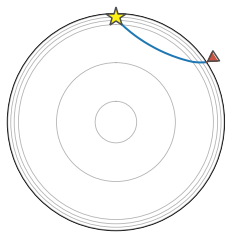

<PolarAxesSubplot:>

In [9]:
arrivals.plot_rays()

## extracting data along the path 

pull out the depth and surface projection (lat/lon) along the path:

In [10]:
path = arrivals[0].path
latlondepths = []

path_frac = np.linspace(0,1,len(path))
for frac,pathpt in zip(path_frac,path):
    ilat,ilon = eq_start.intermediateTo(station_loc,frac).latlon    
    if ilon < 0: 
        ilon = ilon + 360
    latlondepths.append([ilat,ilon,pathpt[3]])

extract a quantity from the yt dataset

In [11]:
path_vs = []
for lld in latlondepths:     
    pt = ds.point(lld[::-1])
    path_vs.append(pt['vs'])

path_vs = np.array(path_vs)
latlondepths = np.array(latlondepths)

plot the surface projection of the ray

yt : [INFO     ] 2021-01-15 15:03:33,508 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-01-15 15:03:33,517 xlim = 0.001000 359.998993
yt : [INFO     ] 2021-01-15 15:03:33,518 ylim = -89.989998 89.989998
yt : [INFO     ] 2021-01-15 15:03:33,519 xlim = 0.001000 359.998993
yt : [INFO     ] 2021-01-15 15:03:33,519 ylim = -89.989998 89.989998
yt : [INFO     ] 2021-01-15 15:03:33,521 Making a fixed resolution buffer of (('stream', 'vs')) 800 by 800
/home/chavlin/miniconda3/envs/yt_dev/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)



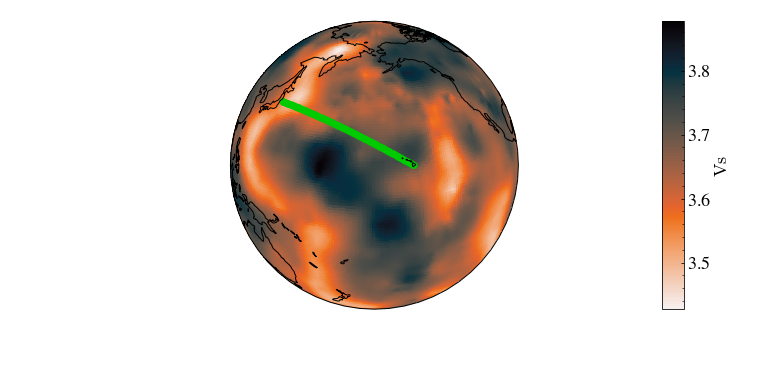

In [12]:
target_depth = 50
center = ds.domain_center
p = yt.SlicePlot(ds,"depth",'vs',center=[target_depth,center[1],center[2]]) 
p.set_cmap('vs', 'dusk_r')
p.set_log('vs', False)
 
p.set_mpl_projection(('NearsidePerspective', (), 
                      {'central_longitude':190.,'central_latitude':20.}))

p._setup_plots()

p.plots['vs'].axes.coastlines()
p.plots['vs'].axes.scatter(latlondepths[:,1],latlondepths[:,0],
           transform=ccrs.PlateCarree(),color=[0,.8,0.,.5])
p.show()


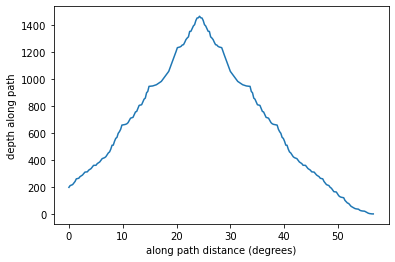

In [13]:
plt.plot(path_frac*gc_dist_deg,latlondepths[:,2])
plt.xlabel("along path distance (degrees)")
plt.ylabel("depth along path")
plt.show()

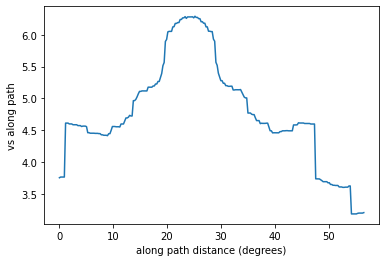

In [14]:
plt.plot(path_frac*gc_dist_deg,path_vs)
plt.xlabel("along path distance (degrees)")
plt.ylabel("vs along path")
plt.show()


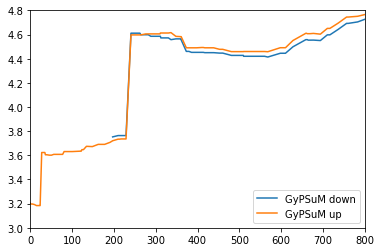

In [15]:
plt.plot(latlondepths[:,2][path_frac<=0.5],path_vs[path_frac<=0.5],label='GyPSuM down')
plt.plot(latlondepths[:,2][path_frac>0.5],path_vs[path_frac>0.5],label='GyPSuM up')
plt.ylim([3,4.8])
plt.xlim([0,800])
plt.legend(loc='lower right')

In [16]:
# compare to the 1d model that generated the raypath.... 

df_iasp91 = pd.read_csv('/home/chavlin/hdd/data/yt_data/IRIS_refModels/IASP91_IDV.csv',header=1)
vs_iasp = np.interp(latlondepths[:,2], df_iasp91['Depth[unit="km"]'], df_iasp91['Vs[unit="km/s"]'])

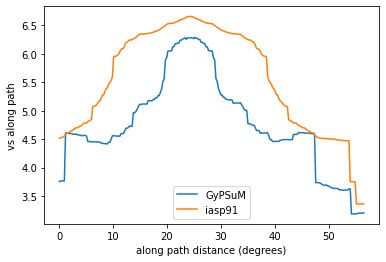

In [17]:
plt.plot(path_frac*gc_dist_deg,path_vs,label='GyPSuM')
plt.plot(path_frac*gc_dist_deg,vs_iasp,label='iasp91')
plt.xlabel("along path distance (degrees)")
plt.ylabel("vs along path")
plt.legend(loc='lower center')
plt.show()

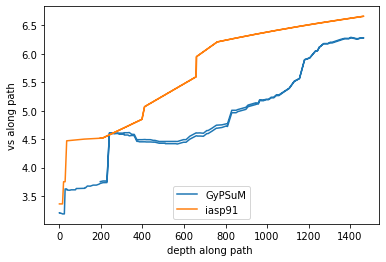

In [18]:
plt.plot(latlondepths[:,2],path_vs,label='GyPSuM')
plt.plot(latlondepths[:,2],vs_iasp,label='iasp91')
plt.xlabel("depth along path ")
plt.ylabel("vs along path")
plt.legend(loc='lower center')
plt.show()